# Test signal generation and processing functions
In this file you can see how generate and process WDM signal

In [221]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from importlib import reload

from hpcom.signal import create_wdm_parameters, generate_wdm
from hpcom.channel import create_channel_parameters

from ssfm_gpu.ssfm_gpu import propagate_manakov

# from signal_handling.processing import get_process_parameters, get_default_process_parameters, get_windowed_signal
import signal_handling.processing as prcs

reload(prcs)

<module 'signal_handling.processing' from '/home/esf0/PycharmProjects/nft_processing/signal_handling/processing.py'>

It is better to allocate memory for GPU before using it

It can take a while for some systems to allocate memory.
But if you will not close jupyter server next runs of gpu-related functions will be fast.
Usually I see such problem for linux systems

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-12-07 09:13:34.997518: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-07 09:13:35.000150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-07 09:13:35.074211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 09:13:35.074643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 Laptop GPU computeCapability: 8.6
coreClock: 1.56GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-12-07 09:13:35.074662: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-07 09:13:35.087512: I tensorflow/stream_executor/p

### Generation of signal and channel

In [213]:
wdm = create_wdm_parameters(n_channels=1, p_ave_dbm=-10, n_symbols=2 ** 12, m_order=16, roll_off=0.1, upsampling=16,
                            downsampling_rate=1, symb_freq=34e9, channel_spacing=75e9, n_polarisations=2, seed='fixed')

channel = create_channel_parameters(n_spans=1,
                                    z_span=80,
                                    alpha_db=0.2,
                                    gamma=1.2,
                                    noise_figure_db=-200,  # -200 means there is no noise
                                    dispersion_parameter=16.8,
                                    dz=1)

In [214]:
signal_x, signal_y, wdm_info = generate_wdm(wdm)
signal = (signal_x, signal_y)

# calculate propagation
start_time = datetime.now()
signal = propagate_manakov(channel, signal[0], signal[1], wdm['sample_freq'])
print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

if wdm['n_polarisations'] == 2:
    signal = (signal[0].numpy(), signal[1].numpy())
else:
    signal = signal.numpy()

filter_values_mean (0.0002441406092657385+0j)
filter_values_mean (0.0002441406092657385+0j)
Signal generation took 57.97 ms
propagation took 94.89200000000001 ms


In [232]:
# get processing parameters
process_parameters = prcs.get_default_process_parameters()
process_parameters['window_mode'] = 'plain'
process_parameters['n_symb_proc'] = 16
process_parameters['n_symb_side'] = 32
process_parameters['n_symb_total'] = process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side']
process_parameters['n_symb_skip'] = 512


for key, value in process_parameters.items():
    print(key, value)

z_prop 0
n_symb_proc 16
n_symb_side 32
n_symb_total 80
n_symb_skip 512
n_symb_add 0
window_mode plain
xi_upsampling 1
forward_continuous_type fnft
forward_discrete_type fnft
forward_discrete_coef_type fnftpoly
inverse_type both
fnft_type 0
nft_type bo
use_contour False
n_discrete_skip 10
print_sys_message False
n_steps 1


In [237]:
process_parameters['window_mode'] = 'plain'
process_parameters['n_symb_add'] = 0
signal_windowed, t_window = prcs.get_windowed_signal(signal, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)

process_parameters['window_mode'] = 'cdc'
process_parameters['n_symb_add'] = 16
signal_windowed_cdc, t_window_cdc = prcs.get_windowed_signal(signal, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)

# for key, value in process_parameters.items():
#     print(key, value)

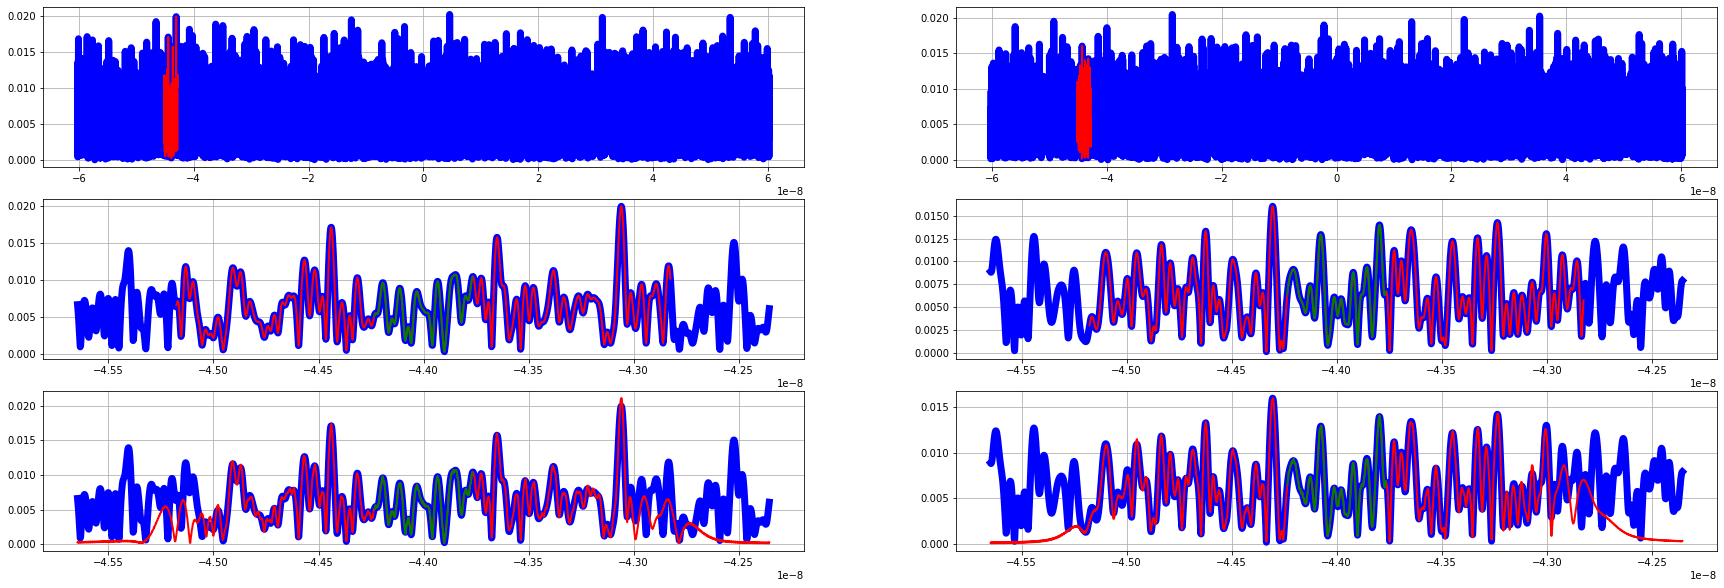

In [238]:
t = (np.arange(len(signal[0])) - len(signal[0]) / 2) / wdm['sample_freq']
plot_shift = 0
range_start = int((process_parameters['n_symb_skip'] - process_parameters['n_symb_add'] - plot_shift) * wdm['upsampling'])
range_end = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_total'] + process_parameters['n_symb_add'] + plot_shift) * wdm['upsampling'])
plot_range = range(range_start, range_end)

range_proc_start = int((process_parameters['n_symb_side'] ) * wdm['upsampling'])
range_proc_end = int((process_parameters['n_symb_side'] + process_parameters['n_symb_proc']) * wdm['upsampling'])
plot_range_proc = range(range_proc_start, range_proc_end)

range_proc_window_start = int((process_parameters['n_symb_side'] + process_parameters['n_symb_add']) * wdm['upsampling'])
range_proc_window_end = int((process_parameters['n_symb_side'] + process_parameters['n_symb_proc'] + process_parameters['n_symb_add']) * wdm['upsampling'])
plot_range_proc_window = range(range_proc_window_start, range_proc_window_end)

fig, axs = plt.subplots(3, 2, figsize=(30, 10))

for k in [0, 1]:
    axs[0][k].plot(t, np.absolute(signal[k]), linewidth=7, color='blue')
    axs[0][k].plot(t_window, np.absolute(signal_windowed[k]), linewidth=2, color='red')
    axs[0][k].grid(True)

    axs[1][k].plot(t[plot_range], np.absolute(signal[k][plot_range]), linewidth=7, color='blue')
    # processing interval with side intervals
    axs[1][k].plot(t_window, np.absolute(signal_windowed[k]), linewidth=2, color='red')
    # processing interval
    axs[1][k].plot(t_window[plot_range_proc], np.absolute(signal_windowed[k][plot_range_proc]), linewidth=2, color='green')
    axs[1][k].grid(True)

    axs[2][k].plot(t[plot_range], np.absolute(signal[k][plot_range]), linewidth=7, color='blue')
    # processing interval with side and additional intervals
    axs[2][k].plot(t_window_cdc, np.absolute(signal_windowed_cdc[k]), linewidth=2, color='red')
    # processing interval
    axs[2][k].plot(t_window_cdc[plot_range_proc_window], np.absolute(signal_windowed_cdc[k][plot_range_proc_window]), linewidth=2, color='green')
    axs[2][k].grid(True)